# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

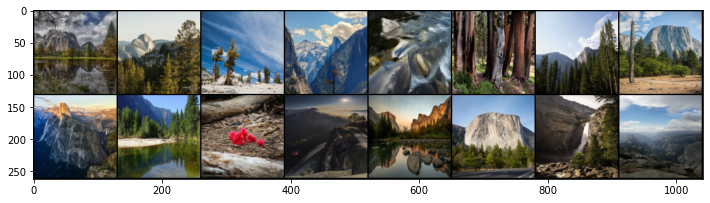

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

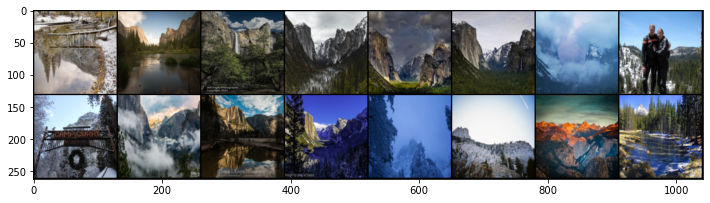

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0157)
Max:  tensor(0.9686)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9686)
Scaled max:  tensor(0.9373)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs a prediction map with depth of one. Contrary to what the figure above indicates, the final output is not required to have a width and depth of one. In the original paper, the authors passed a 4x4 kernel with stride of 1 in the final convolutional layer. You should replicate that strategy.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # identify the first dimension layer
        self.conv_dim = conv_dim
        
        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        
        # depth 3->64 and xy is 128->64
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4, stride=2, batch_norm=False)
        # depth 64->128 and xy is 64->32
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, stride=2, batch_norm=True)
        # depth 128->256 and xy is 32->16
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, stride=2, batch_norm=True)
        # depth 256->512 and xy is 16->8
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=conv_dim*8, kernel_size=4, stride=2, batch_norm=True)
        
        # convolution classification layer
        self.conv5 = conv(in_channels=conv_dim*8, out_channels=1, kernel_size=4, stride=1, batch_norm=False)

    def forward(self, x):
        # define feedforward behavior
        
        # pass through convolution layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs 
        self.conv_dim = conv_dim
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        
        res_net = self.conv1(x)
        res_net = F.relu(res_net)
        res_net = self.conv2(res_net)
        
        output = x + res_net
        
        return output
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # obtain input conv_dim
        self.conv_dim = conv_dim
        
        # 1. Define the encoder part of the generator
        # (128x128x3) -> (64x64x64)
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4, stride=2, batch_norm=True)
        # (64x64x64) -> (32x32x128)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, stride=2, batch_norm=True)
        # (32x32x128) -> (16x16x256)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, stride=2, batch_norm=True)

        # 2. Define the resnet part of the generator
        res_block_List = [ResidualBlock(conv_dim*4) for i in range(n_res_blocks)]
        self.res_block = nn.Sequential(*res_block_List)

        # 3. Define the decoder part of the generator
        # (16x16x256) -> (32x32x128)
        self.deconv1 = deconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, stride=2, batch_norm=True)
        # (32x32x128) -> (64x64x64)
        self.deconv2 = deconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4, stride=2, batch_norm=True)
        # (64x64x64) -> (128x128x3)
        self.deconv3 = deconv(in_channels=conv_dim, out_channels=3, kernel_size=4, stride=2, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        
        # pass through encoder
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        
        # pass through resnet blocks
        x = self.res_block(x)
        
        # pass through decoder
        x = self.deconv1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = F.relu(x)
        x = self.deconv3(x)
        x = F.tanh(x)

        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_block): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
  

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommend calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    real_err = torch.mean((D_out - 1)**2)
    return real_err

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    fake_err = torch.mean((D_out - 0)**2)
    return fake_err

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    return lambda_weight * torch.mean(torch.abs(real_im - reconstructed_im))


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr= .0002
beta1= .5
beta2= .999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [19]:
# import save code
from cyclegan_helpers import save_samples, checkpoint

In [20]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        d_x_real = D_X(images_X)
        d_real_loss_x = real_mse_loss(d_x_real)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_images_x = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        d_fake_x = D_X(fake_images_x)
        d_fake_loss_x = fake_mse_loss(d_fake_x)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = d_real_loss_x + d_fake_loss_x
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        d_y_real = D_Y(images_Y)
        d_real_loss_y = real_mse_loss(d_y_real)

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_images_y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y        
        d_fake_y = D_Y(fake_images_y)
        d_fake_loss_y = fake_mse_loss(d_fake_y)

        # 4. Compute the total loss and perform backprop        
        d_y_loss = d_real_loss_y + d_fake_loss_y
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_images_x = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        g_fake_x = D_X(fake_images_x)
        g_YtoX_loss = real_mse_loss(g_fake_x)
        
        # 3. Create a reconstructed y
        reconstructed_y = G_XtoY(fake_images_x)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_y, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_images_y = G_XtoY(images_X)
        
        # 2. Compute the generator loss based on domain Y
        g_fake_y = D_Y(fake_images_y)
        g_XtoY_loss = real_mse_loss(g_fake_y)
        
        # 3. Create a reconstructed y
        reconstructed_x = G_YtoX(fake_images_y)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_x, lambda_weight=10)        

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_XtoY_loss + g_YtoX_loss + reconstructed_x_loss + reconstructed_y_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
# n_epochs = 1000 # keep this small when testing if a model first works, then increase it to >=1000
n_epochs = 4000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.3454 | d_Y_loss: 0.3806 | g_total_loss: 10.2486
Epoch [   20/ 4000] | d_X_loss: 0.2453 | d_Y_loss: 0.1768 | g_total_loss: 9.0278
Epoch [   30/ 4000] | d_X_loss: 0.4397 | d_Y_loss: 0.2525 | g_total_loss: 7.4303
Epoch [   40/ 4000] | d_X_loss: 0.2485 | d_Y_loss: 0.1597 | g_total_loss: 7.5718
Epoch [   50/ 4000] | d_X_loss: 0.6754 | d_Y_loss: 0.5296 | g_total_loss: 6.3935
Epoch [   60/ 4000] | d_X_loss: 0.6349 | d_Y_loss: 0.4368 | g_total_loss: 6.2493
Epoch [   70/ 4000] | d_X_loss: 0.3001 | d_Y_loss: 0.3935 | g_total_loss: 6.2786
Epoch [   80/ 4000] | d_X_loss: 0.7676 | d_Y_loss: 0.2689 | g_total_loss: 5.6371
Epoch [   90/ 4000] | d_X_loss: 0.4834 | d_Y_loss: 0.5144 | g_total_loss: 6.8878


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.3363 | d_Y_loss: 0.4739 | g_total_loss: 5.9823


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-X-Y.png
Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.6262 | d_Y_loss: 0.2925 | g_total_loss: 5.6584
Epoch [  120/ 4000] | d_X_loss: 0.4623 | d_Y_loss: 0.4298 | g_total_loss: 5.6559
Epoch [  130/ 4000] | d_X_loss: 0.5433 | d_Y_loss: 0.4992 | g_total_loss: 4.9017
Epoch [  140/ 4000] | d_X_loss: 0.3703 | d_Y_loss: 0.4037 | g_total_loss: 6.6091
Epoch [  150/ 4000] | d_X_loss: 0.4747 | d_Y_loss: 0.3766 | g_total_loss: 4.9244
Epoch [  160/ 4000] | d_X_loss: 0.5038 | d_Y_loss: 0.4457 | g_total_loss: 4.3648
Epoch [  170/ 4000] | d_X_loss: 0.4255 | d_Y_loss: 0.4181 | g_total_loss: 5.3849
Epoch [  180/ 4000] | d_X_loss: 0.5222 | d_Y_loss: 0.3439 | g_total_loss: 4.8835
Epoch [  190/ 4000] | d_X_loss: 0.3737 | d_Y_loss: 0.3893 | g_total_loss: 4.7219


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.2952 | d_Y_loss: 0.2514 | g_total_loss: 4.9518


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-X-Y.png
Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.3804 | d_Y_loss: 0.3795 | g_total_loss: 5.2356
Epoch [  220/ 4000] | d_X_loss: 0.3487 | d_Y_loss: 0.3796 | g_total_loss: 4.4583
Epoch [  230/ 4000] | d_X_loss: 0.3314 | d_Y_loss: 0.3849 | g_total_loss: 4.7400
Epoch [  240/ 4000] | d_X_loss: 0.2863 | d_Y_loss: 0.7673 | g_total_loss: 5.0417
Epoch [  250/ 4000] | d_X_loss: 0.5050 | d_Y_loss: 0.5242 | g_total_loss: 4.7627
Epoch [  260/ 4000] | d_X_loss: 0.6239 | d_Y_loss: 0.3543 | g_total_loss: 4.6901
Epoch [  270/ 4000] | d_X_loss: 0.4256 | d_Y_loss: 0.2172 | g_total_loss: 6.2734
Epoch [  280/ 4000] | d_X_loss: 0.3363 | d_Y_loss: 0.3786 | g_total_loss: 5.1706
Epoch [  290/ 4000] | d_X_loss: 0.3009 | d_Y_loss: 0.3595 | g_total_loss: 4.7095
Epoch [  300/ 4000] | d_X_loss: 0.3939 | d_Y_loss: 0.4248 | g_total_loss: 4.4144


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-X-Y.png
Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.6669 | d_Y_loss: 0.4242 | g_total_loss: 4.0853
Epoch [  320/ 4000] | d_X_loss: 0.3087 | d_Y_loss: 0.2497 | g_total_loss: 4.6845
Epoch [  330/ 4000] | d_X_loss: 0.3691 | d_Y_loss: 0.4228 | g_total_loss: 4.6421
Epoch [  340/ 4000] | d_X_loss: 0.3066 | d_Y_loss: 0.2138 | g_total_loss: 5.6124
Epoch [  350/ 4000] | d_X_loss: 0.3824 | d_Y_loss: 0.4465 | g_total_loss: 4.6869
Epoch [  360/ 4000] | d_X_loss: 0.3503 | d_Y_loss: 0.3095 | g_total_loss: 4.6146
Epoch [  370/ 4000] | d_X_loss: 0.4594 | d_Y_loss: 0.3830 | g_total_loss: 4.4303
Epoch [  380/ 4000] | d_X_loss: 0.3407 | d_Y_loss: 0.5289 | g_total_loss: 4.2274
Epoch [  390/ 4000] | d_X_loss: 0.3689 | d_Y_loss: 0.5344 | g_total_loss: 5.4781
Epoch [  400/ 4000] | d_X_loss: 0.4186 | d_Y_loss: 0.3795 | g_total_loss: 5.0708


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-X-Y.png
Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.3794 | d_Y_loss: 0.3508 | g_total_loss: 4.6326
Epoch [  420/ 4000] | d_X_loss: 0.3953 | d_Y_loss: 0.3554 | g_total_loss: 6.0400
Epoch [  430/ 4000] | d_X_loss: 0.3350 | d_Y_loss: 0.3768 | g_total_loss: 4.9198
Epoch [  440/ 4000] | d_X_loss: 0.4047 | d_Y_loss: 0.3752 | g_total_loss: 4.6053
Epoch [  450/ 4000] | d_X_loss: 0.3699 | d_Y_loss: 0.3601 | g_total_loss: 4.5182
Epoch [  460/ 4000] | d_X_loss: 0.4678 | d_Y_loss: 0.2634 | g_total_loss: 4.5831
Epoch [  470/ 4000] | d_X_loss: 0.2676 | d_Y_loss: 0.4459 | g_total_loss: 4.3529
Epoch [  480/ 4000] | d_X_loss: 0.3336 | d_Y_loss: 0.5889 | g_total_loss: 4.0678
Epoch [  490/ 4000] | d_X_loss: 0.2008 | d_Y_loss: 0.5594 | g_total_loss: 4.0815
Epoch [  500/ 4000] | d_X_loss: 0.4002 | d_Y_loss: 0.3415 | g_total_loss: 4.3741


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-X-Y.png
Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.2342 | d_Y_loss: 0.3550 | g_total_loss: 3.9991
Epoch [  520/ 4000] | d_X_loss: 0.4617 | d_Y_loss: 0.2414 | g_total_loss: 4.8973
Epoch [  530/ 4000] | d_X_loss: 0.3361 | d_Y_loss: 0.3964 | g_total_loss: 4.7438
Epoch [  540/ 4000] | d_X_loss: 0.3159 | d_Y_loss: 0.3222 | g_total_loss: 5.0499
Epoch [  550/ 4000] | d_X_loss: 0.3951 | d_Y_loss: 0.4299 | g_total_loss: 4.3257
Epoch [  560/ 4000] | d_X_loss: 0.2573 | d_Y_loss: 0.3351 | g_total_loss: 4.3279
Epoch [  570/ 4000] | d_X_loss: 0.4603 | d_Y_loss: 0.4437 | g_total_loss: 3.7052
Epoch [  580/ 4000] | d_X_loss: 0.3498 | d_Y_loss: 0.4944 | g_total_loss: 4.8118
Epoch [  590/ 4000] | d_X_loss: 0.4420 | d_Y_loss: 0.3832 | g_total_loss: 3.5433
Epoch [  600/ 4000] | d_X_loss: 0.2361 | d_Y_loss: 0.4527 | g_total_loss: 3.7672


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-X-Y.png
Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.3499 | d_Y_loss: 0.5374 | g_total_loss: 5.3175
Epoch [  620/ 4000] | d_X_loss: 0.2665 | d_Y_loss: 0.3568 | g_total_loss: 4.3799
Epoch [  630/ 4000] | d_X_loss: 0.2268 | d_Y_loss: 0.4458 | g_total_loss: 4.2362
Epoch [  640/ 4000] | d_X_loss: 0.4829 | d_Y_loss: 0.3510 | g_total_loss: 4.9873
Epoch [  650/ 4000] | d_X_loss: 0.2833 | d_Y_loss: 0.2940 | g_total_loss: 4.8090
Epoch [  660/ 4000] | d_X_loss: 0.3772 | d_Y_loss: 0.3234 | g_total_loss: 3.7948
Epoch [  670/ 4000] | d_X_loss: 0.2817 | d_Y_loss: 0.4167 | g_total_loss: 5.6756
Epoch [  680/ 4000] | d_X_loss: 0.3294 | d_Y_loss: 0.3204 | g_total_loss: 4.0263
Epoch [  690/ 4000] | d_X_loss: 0.5144 | d_Y_loss: 0.3508 | g_total_loss: 3.5323
Epoch [  700/ 4000] | d_X_loss: 0.3919 | d_Y_loss: 0.3380 | g_total_loss: 4.4917


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-X-Y.png
Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.2619 | d_Y_loss: 0.3630 | g_total_loss: 4.7827
Epoch [  720/ 4000] | d_X_loss: 0.4729 | d_Y_loss: 0.3817 | g_total_loss: 4.5168
Epoch [  730/ 4000] | d_X_loss: 0.4440 | d_Y_loss: 0.3326 | g_total_loss: 3.9927
Epoch [  740/ 4000] | d_X_loss: 0.1371 | d_Y_loss: 0.2970 | g_total_loss: 4.8040
Epoch [  750/ 4000] | d_X_loss: 0.1535 | d_Y_loss: 0.8385 | g_total_loss: 4.4364
Epoch [  760/ 4000] | d_X_loss: 0.9639 | d_Y_loss: 0.2729 | g_total_loss: 3.9338
Epoch [  770/ 4000] | d_X_loss: 0.4144 | d_Y_loss: 0.3296 | g_total_loss: 3.8324
Epoch [  780/ 4000] | d_X_loss: 0.1754 | d_Y_loss: 0.4545 | g_total_loss: 3.9261
Epoch [  790/ 4000] | d_X_loss: 0.2166 | d_Y_loss: 0.2736 | g_total_loss: 4.3638
Epoch [  800/ 4000] | d_X_loss: 0.3567 | d_Y_loss: 0.3304 | g_total_loss: 4.0571


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-X-Y.png
Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.1844 | d_Y_loss: 0.3163 | g_total_loss: 4.2292
Epoch [  820/ 4000] | d_X_loss: 0.3810 | d_Y_loss: 0.2870 | g_total_loss: 3.9381
Epoch [  830/ 4000] | d_X_loss: 0.3319 | d_Y_loss: 0.3477 | g_total_loss: 3.5812
Epoch [  840/ 4000] | d_X_loss: 0.3762 | d_Y_loss: 0.3165 | g_total_loss: 3.8520
Epoch [  850/ 4000] | d_X_loss: 0.4285 | d_Y_loss: 0.3069 | g_total_loss: 5.4576
Epoch [  860/ 4000] | d_X_loss: 0.2978 | d_Y_loss: 0.3968 | g_total_loss: 3.9963
Epoch [  870/ 4000] | d_X_loss: 0.3061 | d_Y_loss: 0.1629 | g_total_loss: 4.0056
Epoch [  880/ 4000] | d_X_loss: 0.3166 | d_Y_loss: 0.3356 | g_total_loss: 5.1799
Epoch [  890/ 4000] | d_X_loss: 0.3108 | d_Y_loss: 0.5045 | g_total_loss: 3.8928


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.3020 | d_Y_loss: 0.3150 | g_total_loss: 3.9928


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-X-Y.png
Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.2623 | d_Y_loss: 0.6705 | g_total_loss: 3.7068
Epoch [  920/ 4000] | d_X_loss: 0.3198 | d_Y_loss: 0.2811 | g_total_loss: 4.2556
Epoch [  930/ 4000] | d_X_loss: 0.3631 | d_Y_loss: 0.2953 | g_total_loss: 4.8471
Epoch [  940/ 4000] | d_X_loss: 0.3556 | d_Y_loss: 0.2237 | g_total_loss: 4.2221
Epoch [  950/ 4000] | d_X_loss: 0.2975 | d_Y_loss: 0.2657 | g_total_loss: 4.2502
Epoch [  960/ 4000] | d_X_loss: 0.3700 | d_Y_loss: 0.3557 | g_total_loss: 3.4459
Epoch [  970/ 4000] | d_X_loss: 0.3574 | d_Y_loss: 0.5707 | g_total_loss: 4.9178
Epoch [  980/ 4000] | d_X_loss: 0.1930 | d_Y_loss: 0.6235 | g_total_loss: 5.2184
Epoch [  990/ 4000] | d_X_loss: 0.3109 | d_Y_loss: 0.3411 | g_total_loss: 4.1278


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.5308 | d_Y_loss: 0.2058 | g_total_loss: 4.1467


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-X-Y.png
Saved samples_cyclegan\sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.4558 | d_Y_loss: 0.3454 | g_total_loss: 3.5514
Epoch [ 1020/ 4000] | d_X_loss: 0.3979 | d_Y_loss: 0.2934 | g_total_loss: 4.1706
Epoch [ 1030/ 4000] | d_X_loss: 0.3665 | d_Y_loss: 0.2865 | g_total_loss: 3.9510
Epoch [ 1040/ 4000] | d_X_loss: 0.2902 | d_Y_loss: 0.3821 | g_total_loss: 4.5341
Epoch [ 1050/ 4000] | d_X_loss: 0.3961 | d_Y_loss: 0.2650 | g_total_loss: 4.4825
Epoch [ 1060/ 4000] | d_X_loss: 0.2696 | d_Y_loss: 0.2869 | g_total_loss: 4.6243
Epoch [ 1070/ 4000] | d_X_loss: 0.2829 | d_Y_loss: 0.3099 | g_total_loss: 4.2370
Epoch [ 1080/ 4000] | d_X_loss: 0.6068 | d_Y_loss: 0.3060 | g_total_loss: 4.1785
Epoch [ 1090/ 4000] | d_X_loss: 0.2002 | d_Y_loss: 0.2650 | g_total_loss: 4.1866


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.2891 | d_Y_loss: 0.9791 | g_total_loss: 5.6970


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-X-Y.png
Saved samples_cyclegan\sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 1.0899 | d_Y_loss: 0.3882 | g_total_loss: 4.8539
Epoch [ 1120/ 4000] | d_X_loss: 0.2614 | d_Y_loss: 0.4248 | g_total_loss: 4.4706
Epoch [ 1130/ 4000] | d_X_loss: 0.3683 | d_Y_loss: 0.4311 | g_total_loss: 3.5114
Epoch [ 1140/ 4000] | d_X_loss: 0.5828 | d_Y_loss: 0.4338 | g_total_loss: 3.5923
Epoch [ 1150/ 4000] | d_X_loss: 0.2781 | d_Y_loss: 0.2645 | g_total_loss: 4.3704
Epoch [ 1160/ 4000] | d_X_loss: 0.1095 | d_Y_loss: 0.3179 | g_total_loss: 4.4378
Epoch [ 1170/ 4000] | d_X_loss: 0.1819 | d_Y_loss: 0.5881 | g_total_loss: 4.7128
Epoch [ 1180/ 4000] | d_X_loss: 0.1475 | d_Y_loss: 0.1504 | g_total_loss: 4.0604
Epoch [ 1190/ 4000] | d_X_loss: 0.2625 | d_Y_loss: 0.2627 | g_total_loss: 5.3518


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.5926 | d_Y_loss: 0.3253 | g_total_loss: 5.4840


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-X-Y.png
Saved samples_cyclegan\sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.2596 | d_Y_loss: 0.3306 | g_total_loss: 4.1253
Epoch [ 1220/ 4000] | d_X_loss: 0.1684 | d_Y_loss: 0.2995 | g_total_loss: 4.3945
Epoch [ 1230/ 4000] | d_X_loss: 0.2454 | d_Y_loss: 0.4778 | g_total_loss: 3.9070
Epoch [ 1240/ 4000] | d_X_loss: 0.3288 | d_Y_loss: 0.3789 | g_total_loss: 4.2967
Epoch [ 1250/ 4000] | d_X_loss: 0.2785 | d_Y_loss: 0.2011 | g_total_loss: 4.6458
Epoch [ 1260/ 4000] | d_X_loss: 0.3050 | d_Y_loss: 0.2757 | g_total_loss: 3.6717
Epoch [ 1270/ 4000] | d_X_loss: 0.2781 | d_Y_loss: 0.3299 | g_total_loss: 4.1170
Epoch [ 1280/ 4000] | d_X_loss: 0.2145 | d_Y_loss: 0.2810 | g_total_loss: 4.6686
Epoch [ 1290/ 4000] | d_X_loss: 0.1357 | d_Y_loss: 0.3479 | g_total_loss: 5.3004
Epoch [ 1300/ 4000] | d_X_loss: 0.0975 | d_Y_loss: 0.4825 | g_total_loss: 5.7517


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-X-Y.png
Saved samples_cyclegan\sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.2400 | d_Y_loss: 0.2620 | g_total_loss: 4.8082
Epoch [ 1320/ 4000] | d_X_loss: 0.4667 | d_Y_loss: 0.3026 | g_total_loss: 5.7091
Epoch [ 1330/ 4000] | d_X_loss: 0.2176 | d_Y_loss: 0.2092 | g_total_loss: 4.5402
Epoch [ 1340/ 4000] | d_X_loss: 0.2330 | d_Y_loss: 0.1970 | g_total_loss: 4.2493
Epoch [ 1350/ 4000] | d_X_loss: 0.1470 | d_Y_loss: 0.2502 | g_total_loss: 4.7175
Epoch [ 1360/ 4000] | d_X_loss: 0.3411 | d_Y_loss: 0.1710 | g_total_loss: 3.8108
Epoch [ 1370/ 4000] | d_X_loss: 0.2353 | d_Y_loss: 0.3149 | g_total_loss: 4.6774
Epoch [ 1380/ 4000] | d_X_loss: 0.4168 | d_Y_loss: 0.2144 | g_total_loss: 3.0863
Epoch [ 1390/ 4000] | d_X_loss: 0.2155 | d_Y_loss: 0.1862 | g_total_loss: 4.5103


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.2222 | d_Y_loss: 0.2616 | g_total_loss: 3.9432


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-X-Y.png
Saved samples_cyclegan\sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.3645 | d_Y_loss: 0.3131 | g_total_loss: 3.9347
Epoch [ 1420/ 4000] | d_X_loss: 0.3949 | d_Y_loss: 0.2251 | g_total_loss: 5.0247
Epoch [ 1430/ 4000] | d_X_loss: 0.4510 | d_Y_loss: 0.2736 | g_total_loss: 3.5723
Epoch [ 1440/ 4000] | d_X_loss: 0.2359 | d_Y_loss: 0.2140 | g_total_loss: 4.2796
Epoch [ 1450/ 4000] | d_X_loss: 0.2372 | d_Y_loss: 0.1583 | g_total_loss: 4.5833
Epoch [ 1460/ 4000] | d_X_loss: 0.2416 | d_Y_loss: 0.1960 | g_total_loss: 4.4797
Epoch [ 1470/ 4000] | d_X_loss: 0.2173 | d_Y_loss: 0.1854 | g_total_loss: 3.9644
Epoch [ 1480/ 4000] | d_X_loss: 0.1881 | d_Y_loss: 0.2785 | g_total_loss: 5.0568
Epoch [ 1490/ 4000] | d_X_loss: 0.2159 | d_Y_loss: 0.4491 | g_total_loss: 4.2987
Epoch [ 1500/ 4000] | d_X_loss: 0.2922 | d_Y_loss: 0.5011 | g_total_loss: 3.9797


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-X-Y.png
Saved samples_cyclegan\sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.2145 | d_Y_loss: 0.3766 | g_total_loss: 5.5554
Epoch [ 1520/ 4000] | d_X_loss: 0.3445 | d_Y_loss: 0.2650 | g_total_loss: 4.8331
Epoch [ 1530/ 4000] | d_X_loss: 0.3749 | d_Y_loss: 0.2176 | g_total_loss: 3.4673
Epoch [ 1540/ 4000] | d_X_loss: 0.1564 | d_Y_loss: 0.3145 | g_total_loss: 5.3491
Epoch [ 1550/ 4000] | d_X_loss: 0.2732 | d_Y_loss: 0.1925 | g_total_loss: 5.2895
Epoch [ 1560/ 4000] | d_X_loss: 0.2579 | d_Y_loss: 0.3018 | g_total_loss: 4.7446
Epoch [ 1570/ 4000] | d_X_loss: 0.5025 | d_Y_loss: 0.3242 | g_total_loss: 5.0027
Epoch [ 1580/ 4000] | d_X_loss: 0.2563 | d_Y_loss: 0.2033 | g_total_loss: 4.4143
Epoch [ 1590/ 4000] | d_X_loss: 0.6680 | d_Y_loss: 0.8900 | g_total_loss: 3.2633
Epoch [ 1600/ 4000] | d_X_loss: 0.2954 | d_Y_loss: 0.2016 | g_total_loss: 4.5284


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001600-X-Y.png
Saved samples_cyclegan\sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.1589 | d_Y_loss: 0.1687 | g_total_loss: 4.4413
Epoch [ 1620/ 4000] | d_X_loss: 0.3277 | d_Y_loss: 0.3677 | g_total_loss: 5.0818
Epoch [ 1630/ 4000] | d_X_loss: 0.2367 | d_Y_loss: 0.1893 | g_total_loss: 4.7972
Epoch [ 1640/ 4000] | d_X_loss: 0.3067 | d_Y_loss: 0.3155 | g_total_loss: 4.1872
Epoch [ 1650/ 4000] | d_X_loss: 0.2168 | d_Y_loss: 0.2186 | g_total_loss: 4.0044
Epoch [ 1660/ 4000] | d_X_loss: 0.1456 | d_Y_loss: 0.3431 | g_total_loss: 4.3592
Epoch [ 1670/ 4000] | d_X_loss: 0.3260 | d_Y_loss: 0.1396 | g_total_loss: 4.4473
Epoch [ 1680/ 4000] | d_X_loss: 0.1303 | d_Y_loss: 0.1153 | g_total_loss: 4.4319
Epoch [ 1690/ 4000] | d_X_loss: 0.1738 | d_Y_loss: 0.4646 | g_total_loss: 5.4324
Epoch [ 1700/ 4000] | d_X_loss: 0.3262 | d_Y_loss: 0.2264 | g_total_loss: 5.5182


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001700-X-Y.png
Saved samples_cyclegan\sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.2476 | d_Y_loss: 0.3326 | g_total_loss: 4.8018
Epoch [ 1720/ 4000] | d_X_loss: 0.7408 | d_Y_loss: 0.1413 | g_total_loss: 3.6377
Epoch [ 1730/ 4000] | d_X_loss: 0.3473 | d_Y_loss: 0.1553 | g_total_loss: 3.9596
Epoch [ 1740/ 4000] | d_X_loss: 0.2549 | d_Y_loss: 0.3810 | g_total_loss: 4.7199
Epoch [ 1750/ 4000] | d_X_loss: 0.2523 | d_Y_loss: 0.3046 | g_total_loss: 4.8576
Epoch [ 1760/ 4000] | d_X_loss: 0.5452 | d_Y_loss: 0.0685 | g_total_loss: 5.3427
Epoch [ 1770/ 4000] | d_X_loss: 0.2257 | d_Y_loss: 0.6317 | g_total_loss: 4.5517
Epoch [ 1780/ 4000] | d_X_loss: 0.3604 | d_Y_loss: 0.4006 | g_total_loss: 4.4666
Epoch [ 1790/ 4000] | d_X_loss: 0.1340 | d_Y_loss: 0.3396 | g_total_loss: 4.5912


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.2242 | d_Y_loss: 0.2354 | g_total_loss: 4.8072


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001800-X-Y.png
Saved samples_cyclegan\sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.1548 | d_Y_loss: 0.2229 | g_total_loss: 3.8300
Epoch [ 1820/ 4000] | d_X_loss: 0.0897 | d_Y_loss: 0.2562 | g_total_loss: 4.9841
Epoch [ 1830/ 4000] | d_X_loss: 0.3853 | d_Y_loss: 0.4465 | g_total_loss: 6.6163
Epoch [ 1840/ 4000] | d_X_loss: 0.1249 | d_Y_loss: 0.1973 | g_total_loss: 4.5540
Epoch [ 1850/ 4000] | d_X_loss: 0.4005 | d_Y_loss: 0.1840 | g_total_loss: 5.0150
Epoch [ 1860/ 4000] | d_X_loss: 0.1240 | d_Y_loss: 0.1787 | g_total_loss: 3.8437
Epoch [ 1870/ 4000] | d_X_loss: 0.1648 | d_Y_loss: 0.3912 | g_total_loss: 4.1362
Epoch [ 1880/ 4000] | d_X_loss: 0.1038 | d_Y_loss: 0.3043 | g_total_loss: 3.7401
Epoch [ 1890/ 4000] | d_X_loss: 0.1003 | d_Y_loss: 0.2440 | g_total_loss: 5.8472
Epoch [ 1900/ 4000] | d_X_loss: 0.0913 | d_Y_loss: 0.1793 | g_total_loss: 4.2677


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001900-X-Y.png
Saved samples_cyclegan\sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.2553 | d_Y_loss: 0.2050 | g_total_loss: 3.7970
Epoch [ 1920/ 4000] | d_X_loss: 0.2244 | d_Y_loss: 0.5263 | g_total_loss: 4.5905
Epoch [ 1930/ 4000] | d_X_loss: 0.2475 | d_Y_loss: 0.1236 | g_total_loss: 3.5249
Epoch [ 1940/ 4000] | d_X_loss: 0.1607 | d_Y_loss: 0.1978 | g_total_loss: 4.7939
Epoch [ 1950/ 4000] | d_X_loss: 0.3375 | d_Y_loss: 0.1156 | g_total_loss: 3.9883
Epoch [ 1960/ 4000] | d_X_loss: 0.1081 | d_Y_loss: 0.1376 | g_total_loss: 4.8562
Epoch [ 1970/ 4000] | d_X_loss: 0.4892 | d_Y_loss: 0.1973 | g_total_loss: 4.6838
Epoch [ 1980/ 4000] | d_X_loss: 0.2247 | d_Y_loss: 0.1229 | g_total_loss: 4.7874
Epoch [ 1990/ 4000] | d_X_loss: 0.1135 | d_Y_loss: 0.1913 | g_total_loss: 4.5421


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.1375 | d_Y_loss: 0.1523 | g_total_loss: 3.6115


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002000-X-Y.png
Saved samples_cyclegan\sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.5755 | d_Y_loss: 0.1619 | g_total_loss: 4.3784
Epoch [ 2020/ 4000] | d_X_loss: 0.1029 | d_Y_loss: 0.1941 | g_total_loss: 4.0800
Epoch [ 2030/ 4000] | d_X_loss: 0.3755 | d_Y_loss: 0.4424 | g_total_loss: 4.5611
Epoch [ 2040/ 4000] | d_X_loss: 0.1436 | d_Y_loss: 0.1844 | g_total_loss: 5.0789
Epoch [ 2050/ 4000] | d_X_loss: 0.1440 | d_Y_loss: 0.1857 | g_total_loss: 4.4238
Epoch [ 2060/ 4000] | d_X_loss: 0.1951 | d_Y_loss: 0.3312 | g_total_loss: 3.3836
Epoch [ 2070/ 4000] | d_X_loss: 0.1542 | d_Y_loss: 0.1811 | g_total_loss: 4.5484
Epoch [ 2080/ 4000] | d_X_loss: 0.4069 | d_Y_loss: 0.1886 | g_total_loss: 3.6602
Epoch [ 2090/ 4000] | d_X_loss: 0.2838 | d_Y_loss: 0.2139 | g_total_loss: 4.7638
Epoch [ 2100/ 4000] | d_X_loss: 0.4108 | d_Y_loss: 0.4111 | g_total_loss: 4.2369


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002100-X-Y.png
Saved samples_cyclegan\sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.1538 | d_Y_loss: 0.4797 | g_total_loss: 3.4462
Epoch [ 2120/ 4000] | d_X_loss: 0.0733 | d_Y_loss: 0.1487 | g_total_loss: 3.9225
Epoch [ 2130/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.2238 | g_total_loss: 3.8038
Epoch [ 2140/ 4000] | d_X_loss: 0.1451 | d_Y_loss: 0.2158 | g_total_loss: 4.3139
Epoch [ 2150/ 4000] | d_X_loss: 0.0918 | d_Y_loss: 0.1223 | g_total_loss: 4.0426
Epoch [ 2160/ 4000] | d_X_loss: 0.1594 | d_Y_loss: 0.2704 | g_total_loss: 4.1533
Epoch [ 2170/ 4000] | d_X_loss: 0.0676 | d_Y_loss: 0.2227 | g_total_loss: 4.2318
Epoch [ 2180/ 4000] | d_X_loss: 0.1337 | d_Y_loss: 0.0995 | g_total_loss: 4.9451
Epoch [ 2190/ 4000] | d_X_loss: 0.1478 | d_Y_loss: 0.3614 | g_total_loss: 4.0879


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.1808 | d_Y_loss: 0.3263 | g_total_loss: 4.6166


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002200-X-Y.png
Saved samples_cyclegan\sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0960 | d_Y_loss: 0.1894 | g_total_loss: 4.0662
Epoch [ 2220/ 4000] | d_X_loss: 0.0648 | d_Y_loss: 0.1284 | g_total_loss: 4.7097
Epoch [ 2230/ 4000] | d_X_loss: 0.3130 | d_Y_loss: 0.2954 | g_total_loss: 3.8433
Epoch [ 2240/ 4000] | d_X_loss: 0.1239 | d_Y_loss: 0.0797 | g_total_loss: 4.1317
Epoch [ 2250/ 4000] | d_X_loss: 0.1561 | d_Y_loss: 0.2360 | g_total_loss: 3.6186
Epoch [ 2260/ 4000] | d_X_loss: 0.1746 | d_Y_loss: 0.2488 | g_total_loss: 5.7500
Epoch [ 2270/ 4000] | d_X_loss: 0.1194 | d_Y_loss: 0.1418 | g_total_loss: 5.6795
Epoch [ 2280/ 4000] | d_X_loss: 0.0355 | d_Y_loss: 0.2223 | g_total_loss: 3.9058
Epoch [ 2290/ 4000] | d_X_loss: 0.0480 | d_Y_loss: 0.1068 | g_total_loss: 4.6365
Epoch [ 2300/ 4000] | d_X_loss: 0.3348 | d_Y_loss: 0.1714 | g_total_loss: 4.5186


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002300-X-Y.png
Saved samples_cyclegan\sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.0976 | d_Y_loss: 0.1458 | g_total_loss: 3.7051
Epoch [ 2320/ 4000] | d_X_loss: 0.0562 | d_Y_loss: 0.2471 | g_total_loss: 3.8511
Epoch [ 2330/ 4000] | d_X_loss: 0.1089 | d_Y_loss: 0.1667 | g_total_loss: 5.5103
Epoch [ 2340/ 4000] | d_X_loss: 0.1507 | d_Y_loss: 0.0586 | g_total_loss: 4.2433
Epoch [ 2350/ 4000] | d_X_loss: 0.2308 | d_Y_loss: 0.2162 | g_total_loss: 5.0878
Epoch [ 2360/ 4000] | d_X_loss: 0.1375 | d_Y_loss: 0.1869 | g_total_loss: 5.0437
Epoch [ 2370/ 4000] | d_X_loss: 0.1267 | d_Y_loss: 0.2633 | g_total_loss: 6.2142
Epoch [ 2380/ 4000] | d_X_loss: 0.1747 | d_Y_loss: 0.1747 | g_total_loss: 4.6513
Epoch [ 2390/ 4000] | d_X_loss: 0.5916 | d_Y_loss: 0.0651 | g_total_loss: 3.6272
Epoch [ 2400/ 4000] | d_X_loss: 0.0668 | d_Y_loss: 0.1957 | g_total_loss: 5.2801


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002400-X-Y.png
Saved samples_cyclegan\sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0778 | d_Y_loss: 0.2224 | g_total_loss: 4.3398
Epoch [ 2420/ 4000] | d_X_loss: 0.1133 | d_Y_loss: 0.1497 | g_total_loss: 4.0293
Epoch [ 2430/ 4000] | d_X_loss: 0.1357 | d_Y_loss: 0.0733 | g_total_loss: 4.7052
Epoch [ 2440/ 4000] | d_X_loss: 0.1799 | d_Y_loss: 0.2082 | g_total_loss: 5.3838
Epoch [ 2450/ 4000] | d_X_loss: 0.0524 | d_Y_loss: 0.1387 | g_total_loss: 3.9227
Epoch [ 2460/ 4000] | d_X_loss: 0.0706 | d_Y_loss: 0.0852 | g_total_loss: 4.9231
Epoch [ 2470/ 4000] | d_X_loss: 0.2429 | d_Y_loss: 0.1278 | g_total_loss: 4.2796
Epoch [ 2480/ 4000] | d_X_loss: 0.0925 | d_Y_loss: 0.0910 | g_total_loss: 4.2641
Epoch [ 2490/ 4000] | d_X_loss: 0.1159 | d_Y_loss: 0.1348 | g_total_loss: 4.8910


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.2481 | d_Y_loss: 0.5549 | g_total_loss: 6.5615


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002500-X-Y.png
Saved samples_cyclegan\sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.0506 | d_Y_loss: 0.1557 | g_total_loss: 5.0783
Epoch [ 2520/ 4000] | d_X_loss: 0.1728 | d_Y_loss: 0.1348 | g_total_loss: 4.4248
Epoch [ 2530/ 4000] | d_X_loss: 0.1085 | d_Y_loss: 0.1272 | g_total_loss: 4.2727
Epoch [ 2540/ 4000] | d_X_loss: 0.0905 | d_Y_loss: 0.3196 | g_total_loss: 4.2494
Epoch [ 2550/ 4000] | d_X_loss: 0.1528 | d_Y_loss: 0.3018 | g_total_loss: 4.7769
Epoch [ 2560/ 4000] | d_X_loss: 0.1448 | d_Y_loss: 0.3169 | g_total_loss: 4.5186
Epoch [ 2570/ 4000] | d_X_loss: 0.0551 | d_Y_loss: 0.2105 | g_total_loss: 3.7234
Epoch [ 2580/ 4000] | d_X_loss: 0.1687 | d_Y_loss: 0.0656 | g_total_loss: 4.6734
Epoch [ 2590/ 4000] | d_X_loss: 0.1797 | d_Y_loss: 0.1036 | g_total_loss: 5.2288
Epoch [ 2600/ 4000] | d_X_loss: 0.2705 | d_Y_loss: 0.1444 | g_total_loss: 3.7719


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002600-X-Y.png
Saved samples_cyclegan\sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0278 | d_Y_loss: 0.1404 | g_total_loss: 4.3549
Epoch [ 2620/ 4000] | d_X_loss: 0.2540 | d_Y_loss: 0.1223 | g_total_loss: 5.0968
Epoch [ 2630/ 4000] | d_X_loss: 0.1550 | d_Y_loss: 0.1545 | g_total_loss: 5.6790
Epoch [ 2640/ 4000] | d_X_loss: 0.1135 | d_Y_loss: 0.2071 | g_total_loss: 5.2569
Epoch [ 2650/ 4000] | d_X_loss: 0.1584 | d_Y_loss: 0.1632 | g_total_loss: 5.0554
Epoch [ 2660/ 4000] | d_X_loss: 0.2977 | d_Y_loss: 0.1205 | g_total_loss: 4.8681
Epoch [ 2670/ 4000] | d_X_loss: 0.1319 | d_Y_loss: 0.1916 | g_total_loss: 4.9266
Epoch [ 2680/ 4000] | d_X_loss: 0.1932 | d_Y_loss: 0.4504 | g_total_loss: 6.2292
Epoch [ 2690/ 4000] | d_X_loss: 0.1204 | d_Y_loss: 0.1913 | g_total_loss: 4.9091
Epoch [ 2700/ 4000] | d_X_loss: 0.0759 | d_Y_loss: 0.1059 | g_total_loss: 4.2112


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002700-X-Y.png
Saved samples_cyclegan\sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.1420 | d_Y_loss: 0.1602 | g_total_loss: 3.8879
Epoch [ 2720/ 4000] | d_X_loss: 0.0702 | d_Y_loss: 0.0781 | g_total_loss: 4.5582
Epoch [ 2730/ 4000] | d_X_loss: 0.4255 | d_Y_loss: 0.1406 | g_total_loss: 3.2788
Epoch [ 2740/ 4000] | d_X_loss: 0.2425 | d_Y_loss: 0.0919 | g_total_loss: 4.7888
Epoch [ 2750/ 4000] | d_X_loss: 0.2697 | d_Y_loss: 0.0889 | g_total_loss: 5.1381
Epoch [ 2760/ 4000] | d_X_loss: 0.0333 | d_Y_loss: 0.1746 | g_total_loss: 4.8743
Epoch [ 2770/ 4000] | d_X_loss: 0.1487 | d_Y_loss: 0.1284 | g_total_loss: 3.9313
Epoch [ 2780/ 4000] | d_X_loss: 0.1594 | d_Y_loss: 0.3206 | g_total_loss: 3.7651
Epoch [ 2790/ 4000] | d_X_loss: 0.2505 | d_Y_loss: 0.1183 | g_total_loss: 5.1038
Epoch [ 2800/ 4000] | d_X_loss: 0.1342 | d_Y_loss: 0.0955 | g_total_loss: 4.0274


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002800-X-Y.png
Saved samples_cyclegan\sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.1427 | d_Y_loss: 0.5439 | g_total_loss: 5.3307
Epoch [ 2820/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.1940 | g_total_loss: 4.1967
Epoch [ 2830/ 4000] | d_X_loss: 0.0962 | d_Y_loss: 0.1775 | g_total_loss: 4.6010
Epoch [ 2840/ 4000] | d_X_loss: 0.0576 | d_Y_loss: 0.0767 | g_total_loss: 4.2651
Epoch [ 2850/ 4000] | d_X_loss: 0.1577 | d_Y_loss: 0.1739 | g_total_loss: 3.7865
Epoch [ 2860/ 4000] | d_X_loss: 0.0261 | d_Y_loss: 0.0862 | g_total_loss: 4.5139
Epoch [ 2870/ 4000] | d_X_loss: 0.4804 | d_Y_loss: 0.3188 | g_total_loss: 7.0153
Epoch [ 2880/ 4000] | d_X_loss: 0.2848 | d_Y_loss: 0.0875 | g_total_loss: 5.2838
Epoch [ 2890/ 4000] | d_X_loss: 0.0835 | d_Y_loss: 0.1148 | g_total_loss: 4.4997
Epoch [ 2900/ 4000] | d_X_loss: 0.0538 | d_Y_loss: 0.0920 | g_total_loss: 4.0959


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002900-X-Y.png
Saved samples_cyclegan\sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.1188 | d_Y_loss: 0.0923 | g_total_loss: 4.1229
Epoch [ 2920/ 4000] | d_X_loss: 0.1188 | d_Y_loss: 0.1598 | g_total_loss: 4.1536
Epoch [ 2930/ 4000] | d_X_loss: 0.0998 | d_Y_loss: 0.1424 | g_total_loss: 3.7379
Epoch [ 2940/ 4000] | d_X_loss: 0.1388 | d_Y_loss: 0.0503 | g_total_loss: 4.0307
Epoch [ 2950/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.0998 | g_total_loss: 3.9019
Epoch [ 2960/ 4000] | d_X_loss: 0.1641 | d_Y_loss: 0.2346 | g_total_loss: 3.9604
Epoch [ 2970/ 4000] | d_X_loss: 0.0485 | d_Y_loss: 0.1370 | g_total_loss: 4.0822
Epoch [ 2980/ 4000] | d_X_loss: 0.0889 | d_Y_loss: 0.0821 | g_total_loss: 4.5416
Epoch [ 2990/ 4000] | d_X_loss: 0.2840 | d_Y_loss: 0.2543 | g_total_loss: 5.5074
Epoch [ 3000/ 4000] | d_X_loss: 0.0328 | d_Y_loss: 0.2186 | g_total_loss: 4.2789


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003000-X-Y.png
Saved samples_cyclegan\sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.1175 | d_Y_loss: 0.1155 | g_total_loss: 4.1918
Epoch [ 3020/ 4000] | d_X_loss: 0.0894 | d_Y_loss: 0.1265 | g_total_loss: 4.9144
Epoch [ 3030/ 4000] | d_X_loss: 0.1267 | d_Y_loss: 0.2046 | g_total_loss: 3.9458
Epoch [ 3040/ 4000] | d_X_loss: 0.1291 | d_Y_loss: 0.4051 | g_total_loss: 3.1061
Epoch [ 3050/ 4000] | d_X_loss: 0.1590 | d_Y_loss: 0.2060 | g_total_loss: 4.3569
Epoch [ 3060/ 4000] | d_X_loss: 0.1025 | d_Y_loss: 0.2044 | g_total_loss: 4.0230
Epoch [ 3070/ 4000] | d_X_loss: 0.0529 | d_Y_loss: 0.1359 | g_total_loss: 4.3754
Epoch [ 3080/ 4000] | d_X_loss: 0.0692 | d_Y_loss: 0.1455 | g_total_loss: 4.7960
Epoch [ 3090/ 4000] | d_X_loss: 0.2728 | d_Y_loss: 0.1530 | g_total_loss: 4.5973
Epoch [ 3100/ 4000] | d_X_loss: 0.0685 | d_Y_loss: 0.1486 | g_total_loss: 4.1834


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003100-X-Y.png
Saved samples_cyclegan\sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.2251 | d_Y_loss: 0.1566 | g_total_loss: 5.9663
Epoch [ 3120/ 4000] | d_X_loss: 0.1862 | d_Y_loss: 0.1601 | g_total_loss: 4.1512
Epoch [ 3130/ 4000] | d_X_loss: 0.0646 | d_Y_loss: 0.1004 | g_total_loss: 3.9940
Epoch [ 3140/ 4000] | d_X_loss: 0.1382 | d_Y_loss: 0.1039 | g_total_loss: 4.5221
Epoch [ 3150/ 4000] | d_X_loss: 0.2439 | d_Y_loss: 0.0871 | g_total_loss: 5.4267
Epoch [ 3160/ 4000] | d_X_loss: 0.0958 | d_Y_loss: 0.1856 | g_total_loss: 4.3016
Epoch [ 3170/ 4000] | d_X_loss: 0.3866 | d_Y_loss: 0.0695 | g_total_loss: 5.1847
Epoch [ 3180/ 4000] | d_X_loss: 0.1167 | d_Y_loss: 0.2937 | g_total_loss: 3.6378
Epoch [ 3190/ 4000] | d_X_loss: 0.0652 | d_Y_loss: 0.1973 | g_total_loss: 3.5152
Epoch [ 3200/ 4000] | d_X_loss: 0.0880 | d_Y_loss: 0.1073 | g_total_loss: 4.7467


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003200-X-Y.png
Saved samples_cyclegan\sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.1007 | d_Y_loss: 0.1547 | g_total_loss: 4.0055
Epoch [ 3220/ 4000] | d_X_loss: 0.1280 | d_Y_loss: 0.1032 | g_total_loss: 4.1562
Epoch [ 3230/ 4000] | d_X_loss: 0.0295 | d_Y_loss: 0.0918 | g_total_loss: 4.6713
Epoch [ 3240/ 4000] | d_X_loss: 0.0883 | d_Y_loss: 0.0824 | g_total_loss: 4.2297
Epoch [ 3250/ 4000] | d_X_loss: 0.0967 | d_Y_loss: 0.1941 | g_total_loss: 4.3538
Epoch [ 3260/ 4000] | d_X_loss: 0.6280 | d_Y_loss: 0.0601 | g_total_loss: 3.6103
Epoch [ 3270/ 4000] | d_X_loss: 0.2011 | d_Y_loss: 0.0961 | g_total_loss: 4.3965
Epoch [ 3280/ 4000] | d_X_loss: 0.1328 | d_Y_loss: 0.1854 | g_total_loss: 3.7011
Epoch [ 3290/ 4000] | d_X_loss: 0.0664 | d_Y_loss: 0.1041 | g_total_loss: 4.2615
Epoch [ 3300/ 4000] | d_X_loss: 0.2280 | d_Y_loss: 0.0685 | g_total_loss: 5.4713


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003300-X-Y.png
Saved samples_cyclegan\sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.0455 | d_Y_loss: 0.0943 | g_total_loss: 4.4202
Epoch [ 3320/ 4000] | d_X_loss: 0.0369 | d_Y_loss: 0.1081 | g_total_loss: 4.7897
Epoch [ 3330/ 4000] | d_X_loss: 0.1079 | d_Y_loss: 0.0645 | g_total_loss: 4.8932
Epoch [ 3340/ 4000] | d_X_loss: 0.0368 | d_Y_loss: 0.1190 | g_total_loss: 4.5035
Epoch [ 3350/ 4000] | d_X_loss: 0.4894 | d_Y_loss: 0.0986 | g_total_loss: 3.8831
Epoch [ 3360/ 4000] | d_X_loss: 0.0634 | d_Y_loss: 0.0516 | g_total_loss: 4.8146
Epoch [ 3370/ 4000] | d_X_loss: 0.0567 | d_Y_loss: 0.1264 | g_total_loss: 4.6616
Epoch [ 3380/ 4000] | d_X_loss: 0.1705 | d_Y_loss: 0.0975 | g_total_loss: 4.0095
Epoch [ 3390/ 4000] | d_X_loss: 0.1192 | d_Y_loss: 0.1158 | g_total_loss: 3.6760
Epoch [ 3400/ 4000] | d_X_loss: 0.0502 | d_Y_loss: 0.1185 | g_total_loss: 4.0022


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003400-X-Y.png
Saved samples_cyclegan\sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.2871 | d_Y_loss: 0.0938 | g_total_loss: 4.8026
Epoch [ 3420/ 4000] | d_X_loss: 0.1100 | d_Y_loss: 0.0738 | g_total_loss: 3.8219
Epoch [ 3430/ 4000] | d_X_loss: 0.1056 | d_Y_loss: 0.0585 | g_total_loss: 3.9662
Epoch [ 3440/ 4000] | d_X_loss: 0.3998 | d_Y_loss: 0.0582 | g_total_loss: 3.9814
Epoch [ 3450/ 4000] | d_X_loss: 0.1337 | d_Y_loss: 0.1157 | g_total_loss: 4.5293
Epoch [ 3460/ 4000] | d_X_loss: 0.1570 | d_Y_loss: 0.0989 | g_total_loss: 3.6097
Epoch [ 3470/ 4000] | d_X_loss: 0.5974 | d_Y_loss: 0.0761 | g_total_loss: 4.0745
Epoch [ 3480/ 4000] | d_X_loss: 0.0544 | d_Y_loss: 0.1549 | g_total_loss: 4.7366
Epoch [ 3490/ 4000] | d_X_loss: 0.0475 | d_Y_loss: 0.0579 | g_total_loss: 4.3845
Epoch [ 3500/ 4000] | d_X_loss: 0.0764 | d_Y_loss: 0.1224 | g_total_loss: 4.0939


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003500-X-Y.png
Saved samples_cyclegan\sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0757 | d_Y_loss: 0.1282 | g_total_loss: 3.9029
Epoch [ 3520/ 4000] | d_X_loss: 0.3957 | d_Y_loss: 0.0896 | g_total_loss: 5.1097
Epoch [ 3530/ 4000] | d_X_loss: 0.0516 | d_Y_loss: 0.0948 | g_total_loss: 4.4541
Epoch [ 3540/ 4000] | d_X_loss: 0.1844 | d_Y_loss: 0.0871 | g_total_loss: 4.5042
Epoch [ 3550/ 4000] | d_X_loss: 0.2444 | d_Y_loss: 0.0779 | g_total_loss: 5.4197
Epoch [ 3560/ 4000] | d_X_loss: 0.0872 | d_Y_loss: 0.1305 | g_total_loss: 3.8965
Epoch [ 3570/ 4000] | d_X_loss: 0.0908 | d_Y_loss: 0.1373 | g_total_loss: 4.8355
Epoch [ 3580/ 4000] | d_X_loss: 0.0730 | d_Y_loss: 0.0930 | g_total_loss: 3.7759
Epoch [ 3590/ 4000] | d_X_loss: 0.0859 | d_Y_loss: 0.0710 | g_total_loss: 4.1837
Epoch [ 3600/ 4000] | d_X_loss: 0.1228 | d_Y_loss: 0.1336 | g_total_loss: 4.2259


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003600-X-Y.png
Saved samples_cyclegan\sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.1227 | d_Y_loss: 0.0463 | g_total_loss: 4.2723
Epoch [ 3620/ 4000] | d_X_loss: 0.0932 | d_Y_loss: 0.0778 | g_total_loss: 3.6423
Epoch [ 3630/ 4000] | d_X_loss: 0.0460 | d_Y_loss: 0.1058 | g_total_loss: 4.4467
Epoch [ 3640/ 4000] | d_X_loss: 0.0823 | d_Y_loss: 0.0600 | g_total_loss: 3.9225
Epoch [ 3650/ 4000] | d_X_loss: 0.0612 | d_Y_loss: 0.2091 | g_total_loss: 4.1748
Epoch [ 3660/ 4000] | d_X_loss: 0.0345 | d_Y_loss: 0.0731 | g_total_loss: 3.9417
Epoch [ 3670/ 4000] | d_X_loss: 0.2133 | d_Y_loss: 0.1713 | g_total_loss: 4.7963
Epoch [ 3680/ 4000] | d_X_loss: 0.1930 | d_Y_loss: 0.1538 | g_total_loss: 5.5493
Epoch [ 3690/ 4000] | d_X_loss: 0.0870 | d_Y_loss: 0.0910 | g_total_loss: 4.3480
Epoch [ 3700/ 4000] | d_X_loss: 0.0561 | d_Y_loss: 0.0805 | g_total_loss: 3.8699


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003700-X-Y.png
Saved samples_cyclegan\sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.2604 | d_Y_loss: 0.0807 | g_total_loss: 3.9546
Epoch [ 3720/ 4000] | d_X_loss: 0.1506 | d_Y_loss: 0.1292 | g_total_loss: 4.1100
Epoch [ 3730/ 4000] | d_X_loss: 0.2022 | d_Y_loss: 0.6165 | g_total_loss: 3.6819
Epoch [ 3740/ 4000] | d_X_loss: 0.0548 | d_Y_loss: 0.0944 | g_total_loss: 4.3377
Epoch [ 3750/ 4000] | d_X_loss: 0.0544 | d_Y_loss: 0.1135 | g_total_loss: 5.0892
Epoch [ 3760/ 4000] | d_X_loss: 0.0415 | d_Y_loss: 0.2272 | g_total_loss: 5.3016
Epoch [ 3770/ 4000] | d_X_loss: 0.1650 | d_Y_loss: 0.0818 | g_total_loss: 3.9446
Epoch [ 3780/ 4000] | d_X_loss: 0.3589 | d_Y_loss: 0.1544 | g_total_loss: 3.9480
Epoch [ 3790/ 4000] | d_X_loss: 0.2608 | d_Y_loss: 0.1548 | g_total_loss: 4.8206
Epoch [ 3800/ 4000] | d_X_loss: 0.1454 | d_Y_loss: 0.0653 | g_total_loss: 3.8402


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003800-X-Y.png
Saved samples_cyclegan\sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.1531 | d_Y_loss: 0.0614 | g_total_loss: 4.6056
Epoch [ 3820/ 4000] | d_X_loss: 0.1372 | d_Y_loss: 0.1766 | g_total_loss: 4.3120
Epoch [ 3830/ 4000] | d_X_loss: 0.1370 | d_Y_loss: 0.0705 | g_total_loss: 4.4278
Epoch [ 3840/ 4000] | d_X_loss: 0.1006 | d_Y_loss: 0.1225 | g_total_loss: 3.6151
Epoch [ 3850/ 4000] | d_X_loss: 0.0400 | d_Y_loss: 0.0614 | g_total_loss: 3.7473
Epoch [ 3860/ 4000] | d_X_loss: 0.0874 | d_Y_loss: 0.2969 | g_total_loss: 5.0492
Epoch [ 3870/ 4000] | d_X_loss: 0.3797 | d_Y_loss: 0.0710 | g_total_loss: 4.6766
Epoch [ 3880/ 4000] | d_X_loss: 0.1848 | d_Y_loss: 0.1631 | g_total_loss: 4.4119
Epoch [ 3890/ 4000] | d_X_loss: 0.2446 | d_Y_loss: 0.1092 | g_total_loss: 3.3305


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.0634 | d_Y_loss: 0.0537 | g_total_loss: 5.5387


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003900-X-Y.png
Saved samples_cyclegan\sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.1185 | d_Y_loss: 0.2378 | g_total_loss: 4.7517
Epoch [ 3920/ 4000] | d_X_loss: 0.1589 | d_Y_loss: 0.0881 | g_total_loss: 4.5420
Epoch [ 3930/ 4000] | d_X_loss: 0.1147 | d_Y_loss: 0.1081 | g_total_loss: 3.6711
Epoch [ 3940/ 4000] | d_X_loss: 0.1363 | d_Y_loss: 0.0852 | g_total_loss: 3.7682
Epoch [ 3950/ 4000] | d_X_loss: 0.2915 | d_Y_loss: 0.0730 | g_total_loss: 3.7424
Epoch [ 3960/ 4000] | d_X_loss: 0.0393 | d_Y_loss: 0.0547 | g_total_loss: 4.2180
Epoch [ 3970/ 4000] | d_X_loss: 0.1077 | d_Y_loss: 0.0834 | g_total_loss: 4.3598
Epoch [ 3980/ 4000] | d_X_loss: 0.0736 | d_Y_loss: 0.1256 | g_total_loss: 4.6585
Epoch [ 3990/ 4000] | d_X_loss: 0.0988 | d_Y_loss: 0.0476 | g_total_loss: 4.4898


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.0929 | d_Y_loss: 0.0839 | g_total_loss: 3.4539


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004000-X-Y.png
Saved samples_cyclegan\sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


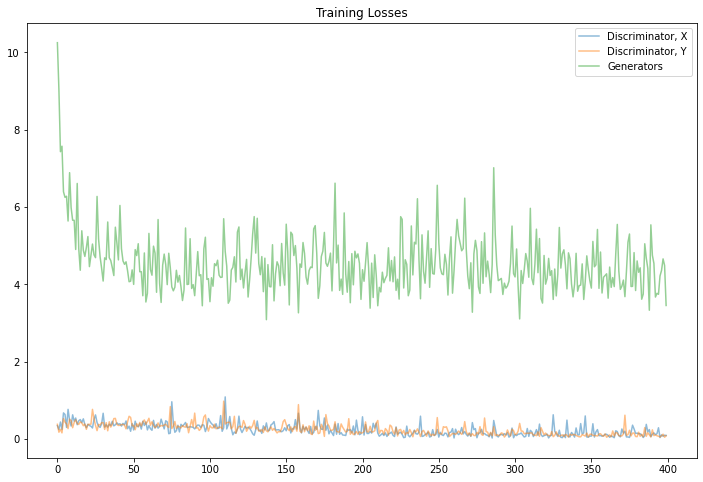

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [23]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


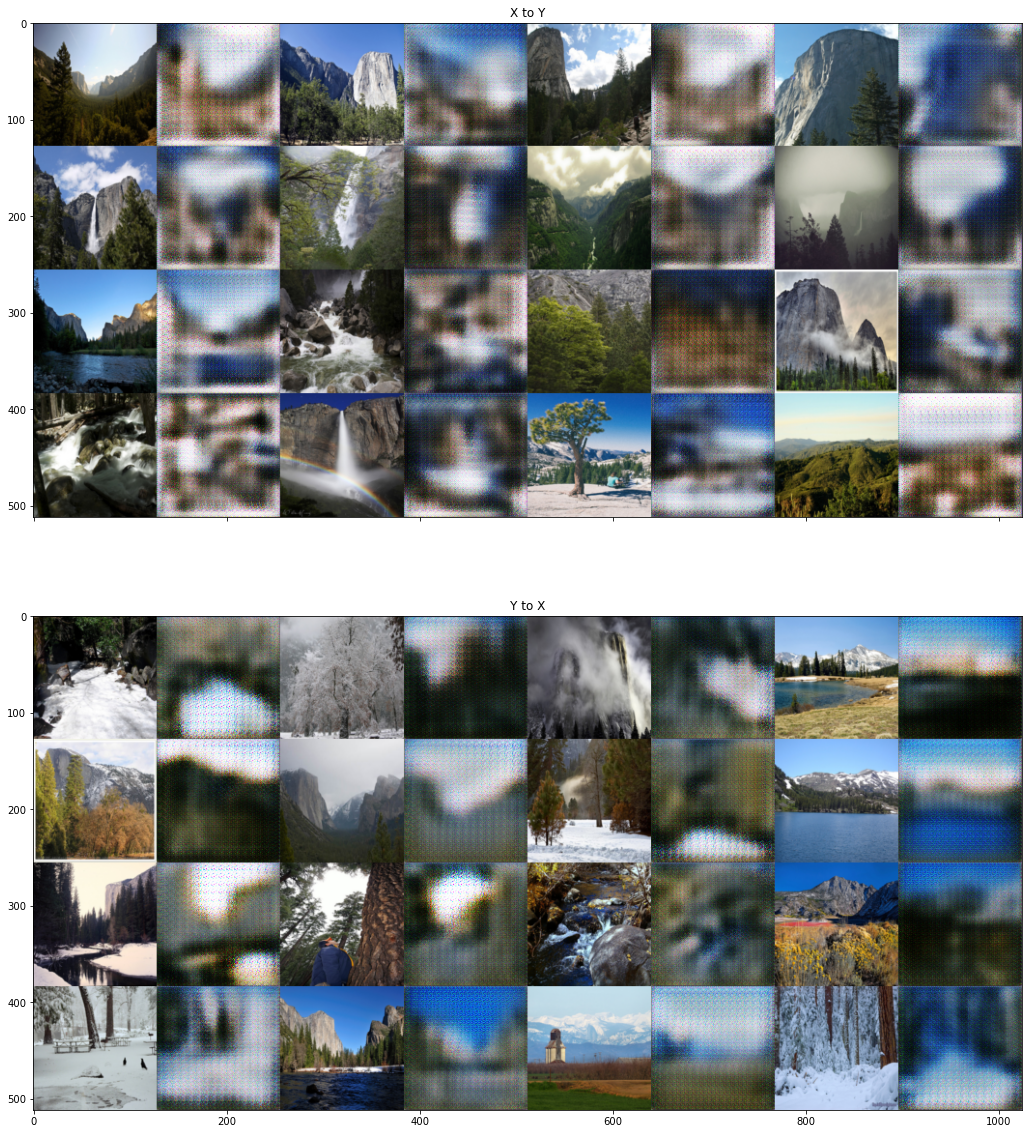

In [24]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

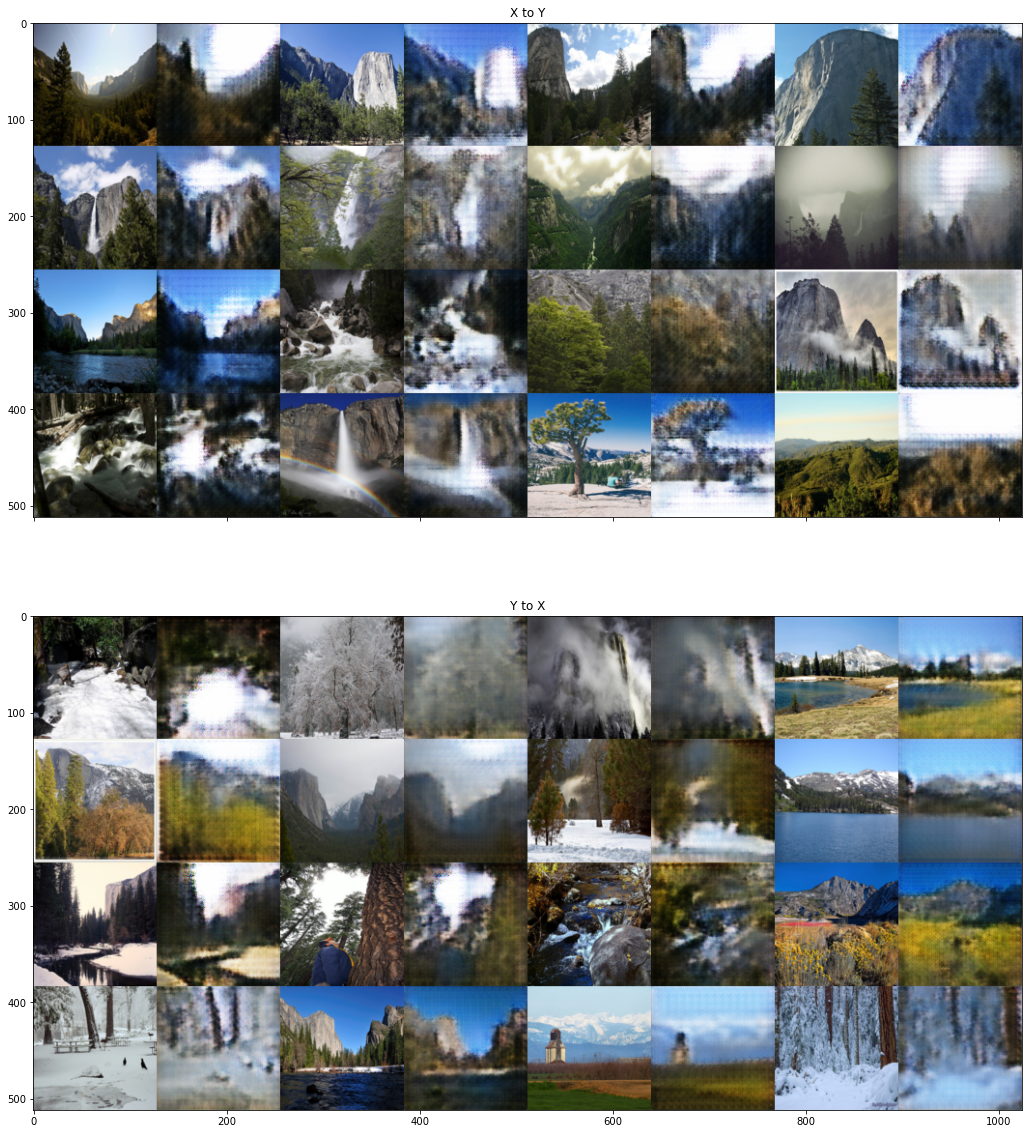

In [25]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.